In [140]:
import pandas as pd
import os
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, roc_curve, auc, precision_recall_curve, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

# Load the dataset
absolute_path = (str(os.path.abspath('')))
parent_path = os.path.dirname(absolute_path)
relative_path = "Datasets/UniversalBank.csv"
dataset_path = os.path.join(parent_path, relative_path)
print(dataset_path)

# Read the dataset
df = pd.read_csv(dataset_path)

#The goal for this logistic regression is to be able to
#predict the CreditCard property. The CreditCard property is a qualitative variable
#which has value 1 or 0. Where a 1 means that the person uses a CreditCard, and a 0 means that the person does not.


c:\Users\jordy\Data science\DSopdrachten\Datasets/UniversalBank.csv


In [106]:
#First, I will Standardize the numerical columns, I have chosen standardization instead of normalization because it visualises outliers better
# and because it is better suited for regression.
#For that I will first need to identify the numerical columns.

numerical_columns = ['Age', 'Experience', 'Income', 'ZIP Code', 'Family', 'CCAvg', 'Education', 'Mortgage']
scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[list(numerical_columns)])

In [107]:
#Secondly, I will drop the ID column, since it adds no statistical value for analysis.
df_cleaned = df.drop(columns=['ID'])

In [108]:
#Now that we have a cleaned and standardized dataframe, let's define the predictors and target
#I will for now pick every column, that is not the target as the predictor
#to train the model independently and see which yields better results
print(df_cleaned.columns.tolist())
target = ['CreditCard']
predictors = ['Age', 'Experience', 'Income', 'ZIP Code', 'Family', 'CCAvg', 'Education', 'Mortgage', 'Personal Loan', 'Securities Account', 'CD Account', 'Online']

['Age', 'Experience', 'Income', 'ZIP Code', 'Family', 'CCAvg', 'Education', 'Mortgage', 'Personal Loan', 'Securities Account', 'CD Account', 'Online', 'CreditCard']


In [109]:
#Now that we have our predictors and target, let's split the dataframe into test- and traindata.
#For now I will train the model on 80% of data, this might be changed later.
x = df_cleaned.drop(target, axis=1)
y = df_cleaned[target]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
y_train = y_train.values.ravel()

In [110]:
#We now have a split dataframe, next I would like to create many models, using every possible combination of predictors to see which results in the best model.
#I am aware that this is not always recommended, since the compute power required increases exponentially for each added predictor. But since the dataset 
#is not that big, it should be fine.
results = []

# Generate all non-empty combinations of predictors
for r in range(1, len(predictors) + 1):
    for subset in itertools.combinations(predictors, r):
        # Fit logistic regression model
        model = LogisticRegression(solver='liblinear', random_state=42)
        model.fit(X_train[list(subset)], y_train)

        # Predict on the test set
        y_pred = model.predict(X_test[list(subset)])

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)

        # Append results
        results.append({'combination': subset, 'accuracy': accuracy})

In [111]:
# Sort results by accuracy
results.sort(key=lambda x: x['accuracy'], reverse=True)

In [112]:
# Assuming 'results' contains the outcome of your models
# Sort results by accuracy
results.sort(key=lambda x: x['accuracy'], reverse=True)

In [113]:
top_results = results[:100]  # Limit to the first 100 results

accuracies = [result['accuracy'] for result in top_results]
combinations_lengths = [len(result['combination']) for result in top_results]
positions = list(range(len(top_results)))  # Position of each combination in the sorted list

# Prepare x-axis labels combining the number of predictors and their position
x_labels = [f"{combinations_lengths[i]} pred,(Pos {i+1})" for i in positions]

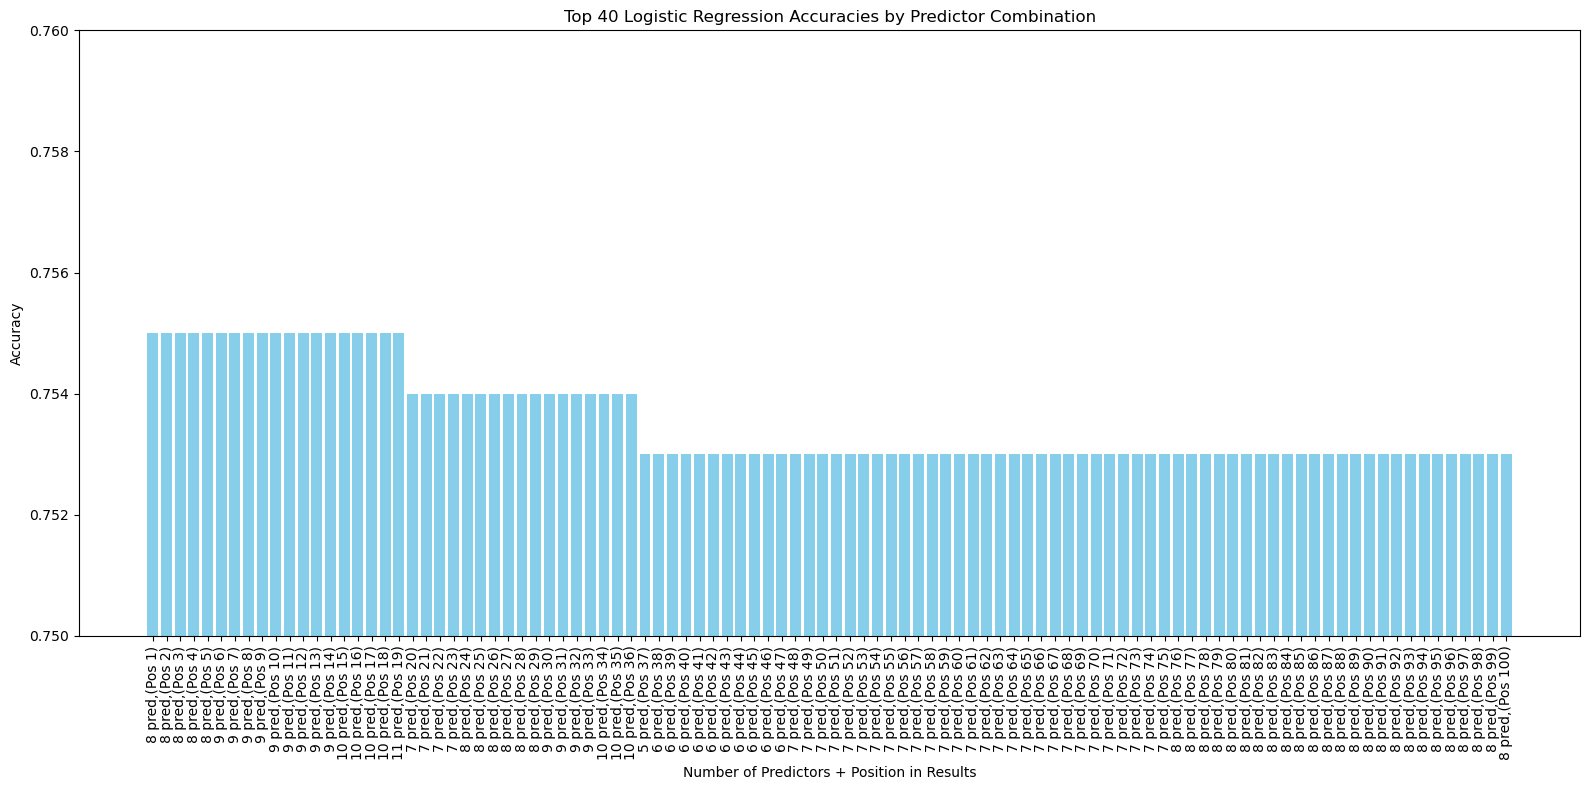

In [114]:
plt.figure(figsize=(16, 8))  # Set the figure size
plt.bar(x_labels, accuracies, color='skyblue')  # Create a bar chart with skyblue color
plt.xlabel('Number of Predictors + Position in Results')  # X-axis label
plt.ylabel('Accuracy')  # Y-axis label
plt.title('Top 40 Logistic Regression Accuracies by Predictor Combination')  # Graph title
plt.ylim(0.750, 0.760)
plt.xticks(rotation=90)  # Rotate x-axis labels to avoid overlapping
plt.tight_layout()  # Adjust layout to make sure everything fits without clipping
plt.show()

In [115]:
#The best performing model seems to have the predictors [Income,Family,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online]
#But an accuracy of .755 is subpar, let's see if the accuracy can be increased through varying the cut-off value with these predictors

In [121]:
target = ['CreditCard']
predictors = ['Income', 'Family', 'Education', 'Mortgage', 'Personal Loan', 'Securities Account', 'CD Account, Online']
x = df_cleaned.drop(target, axis=1)
y = df_cleaned[target]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
y_train = y_train.values.ravel() #to prevent the dataconversionwarning
model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

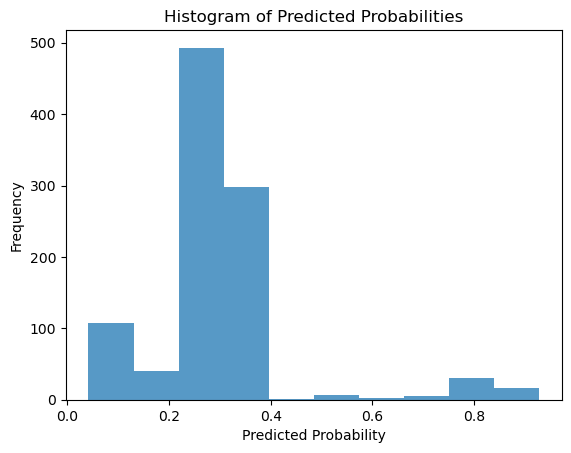

In [117]:
#to set a proper cutoff value, I first have to predict the probabilities
# Assuming 'logreg' is your trained logistic regression model and 'X_test' is your test dataset
y_probs = model.predict_proba(X_test)[:, 1]  
plt.hist(y_probs, bins=10, alpha=0.75)
plt.title('Histogram of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

In [118]:
#Let's now try different tresholds, starting at 0.1 and increasing by 0.1 until 1 is reached to see how it impacts the precision, recall and accuracy.
thresholds = np.linspace(0, 1, 10)
results = []
for thresh in thresholds:
    y_pred = (y_probs >= thresh).astype(int)
    precision = precision_score(y_test, y_pred, zero_division=1)
    recall = recall_score(y_test, y_pred, zero_division=1)
    f1 = f1_score(y_test, y_pred, zero_division=1)
    accuracy = accuracy_score(y_test, y_pred)
    
    results.append({'threshold': thresh, 'precision': precision, 'recall': recall, 'f1_score': f1, 'accuracy': accuracy})

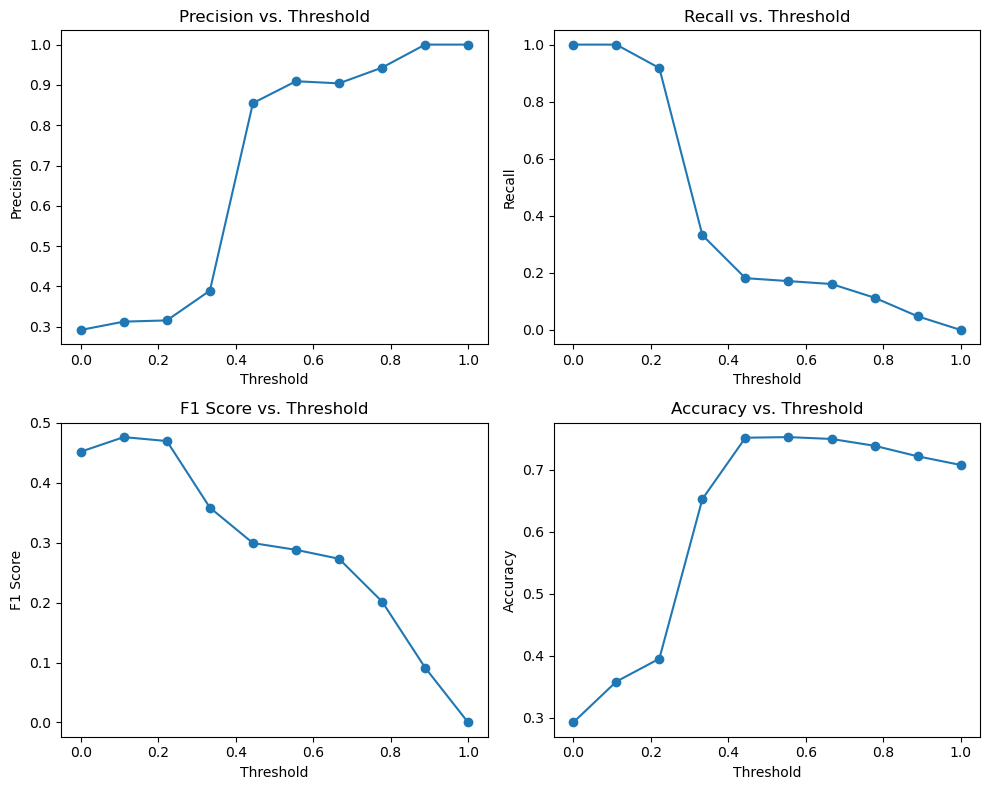

In [119]:
#Let's visualize the results
# Unpack metrics for plotting
thresholds = [res['threshold'] for res in results]
precisions = [res['precision'] for res in results]
recalls = [res['recall'] for res in results]
f1_scores = [res['f1_score'] for res in results]
accuracies = [res['accuracy'] for res in results]

plt.figure(figsize=(10, 8))

# Create subplots for each metric
plt.subplot(2, 2, 1)
plt.plot(thresholds, precisions, marker='o', label='Precision')
plt.title('Precision vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Precision')

plt.subplot(2, 2, 2)
plt.plot(thresholds, recalls, marker='o', label='Recall')
plt.title('Recall vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Recall')

plt.subplot(2, 2, 3)
plt.plot(thresholds, f1_scores, marker='o', label='F1 Score')
plt.title('F1 Score vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')

plt.subplot(2, 2, 4)
plt.plot(thresholds, accuracies, marker='o', label='Accuracy')
plt.title('Accuracy vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

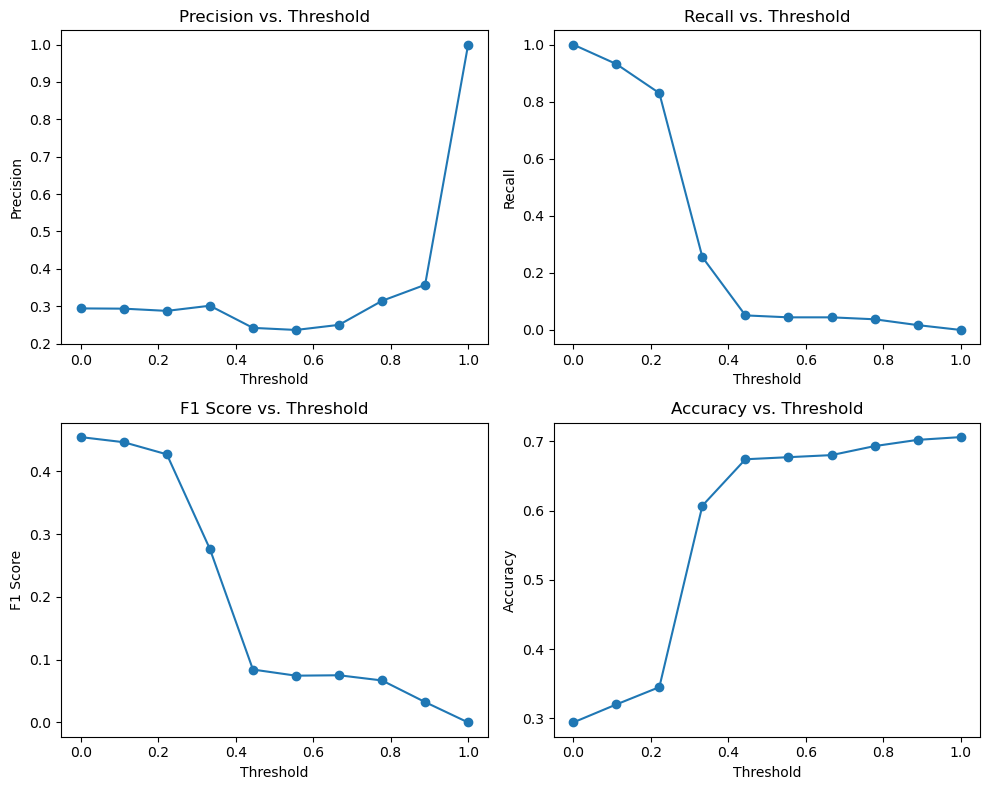

In [124]:
#Above graphs show that a threshold of 0.8 has positive impact on the precision of te model, without severely impacting the accuracy.
#let's stratify the dataframe with stratify=y, to ensure the target is represented equally in the train and test dataset.
# and see how it impacts the accuracy scores

target = ['CreditCard']
predictors = ['Income', 'Family', 'Education', 'Mortgage', 'Personal Loan', 'Securities Account', 'CD Account, Online']
x = df_cleaned.drop(target, axis=1)
y = df_cleaned[target]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)
y_train = y_train.values.ravel() #to prevent the dataconversionwarning
model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(X_train, y_train)

thresholds = np.linspace(0, 1, 10)
results = []
for thresh in thresholds:
    y_pred = (y_probs >= thresh).astype(int)
    precision = precision_score(y_test, y_pred, zero_division=1)
    recall = recall_score(y_test, y_pred, zero_division=1)
    f1 = f1_score(y_test, y_pred, zero_division=1)
    accuracy = accuracy_score(y_test, y_pred)
    
    results.append({'threshold': thresh, 'precision': precision, 'recall': recall, 'f1_score': f1, 'accuracy': accuracy})

# Unpack metrics for plotting
thresholds = [res['threshold'] for res in results]
precisions = [res['precision'] for res in results]
recalls = [res['recall'] for res in results]
f1_scores = [res['f1_score'] for res in results]
accuracies = [res['accuracy'] for res in results]

plt.figure(figsize=(10, 8))

# Create subplots for each metric
plt.subplot(2, 2, 1)
plt.plot(thresholds, precisions, marker='o', label='Precision')
plt.title('Precision vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Precision')

plt.subplot(2, 2, 2)
plt.plot(thresholds, recalls, marker='o', label='Recall')
plt.title('Recall vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Recall')

plt.subplot(2, 2, 3)
plt.plot(thresholds, f1_scores, marker='o', label='F1 Score')
plt.title('F1 Score vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')

plt.subplot(2, 2, 4)
plt.plot(thresholds, accuracies, marker='o', label='Accuracy')
plt.title('Accuracy vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [133]:
#This does not produce acceptable results, stratify=y impacts the precision significantly at a treshold < 0.9, while not meaningfully impacting the accuracy of the model.
#it seems like we need to implemented some balancing methods. Let's try both over-sampling and undersampling using SMOTE and see how it impacts the model. 
# let's first try SMOTE
target = ['CreditCard']
predictors = ['Income', 'Family', 'Education', 'Mortgage', 'Personal Loan', 'Securities Account', 'CD Account, Online']
x = df_cleaned.drop(target, axis=1)
y = df_cleaned[target]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
y_train = y_train.values.ravel() #to prevent the dataconversionwarning
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(X_train_balanced, y_train_balanced)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
#meh

              precision    recall  f1-score   support

           0       0.74      0.62      0.67       708
           1       0.33      0.46      0.39       292

    accuracy                           0.57      1000
   macro avg       0.54      0.54      0.53      1000
weighted avg       0.62      0.57      0.59      1000

Accuracy: 0.574


In [136]:
#Let's try undersampling this time
target = ['CreditCard']
predictors = ['Income', 'Family', 'Education', 'Mortgage', 'Personal Loan', 'Securities Account', 'CD Account, Online']
df_majority = df[df['CreditCard'] == 0]
df_minority = df[df['CreditCard'] == 1]
df_majority_undersampled = resample(df_majority,
                                    replace=False,    # Sample without replacement
                                    n_samples=len(df_minority), # Match number of minority class
                                    random_state=42)  # Reproducible results

# Combine minority class with undersampled majority class
df_balanced = pd.concat([df_majority_undersampled, df_minority])
X_train, X_test, y_train, y_test = train_test_split(df_balanced.drop('CreditCard', axis=1), df_balanced['CreditCard'], test_size=0.2, random_state=42)
model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

              precision    recall  f1-score   support

           0       0.54      0.64      0.59       301
           1       0.53      0.43      0.47       287

    accuracy                           0.54       588
   macro avg       0.53      0.53      0.53       588
weighted avg       0.53      0.54      0.53       588

Accuracy: 0.5357142857142857


In [164]:
#undersampling also provides unsatisfactory results. It would seem the best precision to accuracy ratio comes from the original model,
# with a treshold of ~.55, let's provide the final model below
target = ['CreditCard']
predictors = ['Income', 'Family', 'Education', 'Mortgage', 'Personal Loan', 'Securities Account', 'CD Account, Online']
x = df_cleaned.drop(target, axis=1)
y = df_cleaned[target]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
y_train = y_train.values.ravel() #to prevent the dataconversionwarning
model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(X_train, y_train)
y_probs = model.predict_proba(X_test)[:, 1]
y_pred_custom = (y_probs >= 0.285).astype(int)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred_custom)
print("Accuracy:", accuracy)

# Generating a classification report
print(classification_report(y_test, y_pred_custom))

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_custom))

Accuracy: 0.553
              precision    recall  f1-score   support

           0       0.73      0.58      0.65       708
           1       0.32      0.48      0.39       292

    accuracy                           0.55      1000
   macro avg       0.53      0.53      0.52      1000
weighted avg       0.61      0.55      0.57      1000

Confusion Matrix:
 [[413 295]
 [152 140]]


In [ ]:
#it proves difficult to maximize for f1 score and accuracy. I am at a loss, I have no clue how to go further. I will now kill myself